<a href="https://colab.research.google.com/github/wooohoooo/Thompson-Sampling-Examples/blob/master/Handmade_Bandit_solvers_Linear_Context.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intro

This notebook continues the series about multi-armed bandit (MAB) solutions.
This time we will look at MAB with linear contexts. To understand this, you should at least have an understanding of non-contextual Thompson Sampling, as presented e.g. here [link other notebook].

Like in the previous post, we will first look at the problem at hand and how we can emulate a an environment that can benefit from a contextual MAB solver.
In the previous entry, we looked into the problem of how to find out which arm is better, such as whether a red button or a blue button is likely to generate more traffic to our website, or whether Neo is more likely to choose the red or the blue pill so we can hide the tracer inside (I rewatched the move in the mean time and am now more up to date).

This time, we will add context to the decision, this could be the users age, the users gender, the users education, any other information about the user or any combination thereof. In general, we want to use all the information available to us to make sure our decision is well informed; but in this case we will go for a context of two variables to make sure we can visualize it nicely. 
In our case, it will be the age of the user and whether he has a dog or not; because with age their eyesight grows worse so they don't see th button as well, but people with a dog are more trained to spot small things so less so for them. All correlations in this example are (obviously) completely made up.

![alt](https://live.staticflickr.com/2655/3933458622_3d0956e72d_b.jpg)
(I couldn't find an image of a dog as bandit, so this pawrate will have to be enought)


As we learned last time, in order to use Thompson Sampling, we need distributions over the expected outcome of each arm; while we were using simple beta binomials for the non-contextual case, now we will be using Normal Distributions. Since we also want to include context, we need a way of generating these distributions from a model that incorporates this context. 
For this simple notebook, we will walk through a contextual example using a normal distribution derived via Bayesian Linear Regression. More complex solutions exist, notably one introduced in this paper: ![TS with Online Bootstrap](https://arxiv.org/abs/1410.4009).

Again, this is aimed at application designers rather than students of th mathematicl descriptions behind Thompson Sampling. A primer and possibly a deeper explanation on these topics migh follow in the future. 

But let's take a step back and look at the problem we're trying to solve.






# getting ready 

In [0]:
#maths
import numpy as np
import scipy.stats as stats
from sklearn.utils import shuffle

np.random.seed(42)

In [0]:
#pretty things

matplotlib_style = 'seaborn-notebook' #@param ['fivethirtyeight', 'bmh', 'ggplot', 'seaborn', 'default', 'Solarize_Light2', 'classic', 'dark_background', 'seaborn-colorblind', 'seaborn-notebook']
import matplotlib.pyplot as plt; plt.style.use(matplotlib_style)
import matplotlib.axes as axes;
from matplotlib.patches import Ellipse
import matplotlib.cm as cm

%matplotlib inline
import seaborn as sns; sns.set_context('notebook')
from IPython.core.pylabtools import figsize
#@markdown This sets the resolution of the plot outputs (`retina` is the highest resolution)
notebook_screen_res = 'retina' #@param ['retina', 'png', 'jpeg', 'svg', 'pdf']
%config InlineBackend.figure_format = notebook_screen_res

width = "16" #@param [16,8,25]
height = "4.5" #@param [4.5, 9,16,8,25]
width = int(width)
height = float(height)


plt.rcParams['figure.figsize'] = width,height


In [0]:
#set some parameters

# number of features
num_features = "1" #@param [1, 2,3,50]
num_features = int(num_features)

# data size
num_data = "100" #@param[25,100]
num_data = int(num_data)


# slopes of reward depending for arm 1 and arm 2
theta1 = 2
theta2 = 10
theta = [int(theta1), int(theta2)]

# noise in the data
noise = "5" #@param [1,5,10,100]
noise = int(noise)


# scale of uncertainty
v = "100"#@param [1,10, 50, 100]

v = int(v)


# What is a contextual multi armed bandit situation?

The contextual multi armed bandit situation is similar to the one we encountered previously. We have a deicsion to make, and depending on that decision, we will get a reward. Not much new, so far. We want to know whether a dog on our website makes the user pay more for our product, think Humble Bundle.

As we did last time, we have to define a 'user' that will react to the arms we play. And as last time, we do this via a function called 'customer_reaction'. 

However, this time we have have some information about the user, formally known as context. In this case, it is the users age (1). We think that depending on how old the users are, they will react DIFFERENTLY to whether a dog is present or not. Here it is 'the older you are, the more you spending increases when you see a dog', meaning showing people a dog is the best decision above a certain age; below that age we're more likely to receive more money if we DO NOT SHOW A DOG.


This we'll model as a linear slope with 

$y = x \cdot m + t + \epsilon $

where 
$y$ is the target, i.e. how much the user spends

$x$ is the context, i.e. the users age

$m$ is a linear factor decided by whether a dog is present or not

$t$ is the onset; in our case that is 0

$\epsilon$ is gaussian noise, since we're still in a probabilistic setting


 (1) the users age is between -10 and 10 in this case. If you have a problem with this... redo this notebook with more sensible numbers. Have fun! 


In [0]:
X_ = np.array([1,2,3])
arm = np.array([1,2])

num_arms = 1
num_contexts = 1
#num_data = 1000

#create X
X = np.zeros((num_data,num_contexts + num_arms))


for i in range(num_contexts):
    X[:,i] = np.linspace(-10,10,num_data).T
    
for i in range(num_arms):
    X[:,i+num_contexts] = np.random.binomial(1,.6,num_data)
X[:5,:]

X = shuffle(X)

 

In [0]:
def customer_reaction(context, choice, theta = theta, noise=noise):
  features  = np.append(context,choice)


  # decide on which slope to use depending on whether a dog is present or not
  m = theta[0] if features[1] else theta[1]

  # $y = x \cdot m + t + \epsilon $
  y = features[0] * m + np.random.normal(0,noise)


  return y


In [6]:
customer_reaction([9.0],1)

17.282688851846554

In [7]:
customer_reaction([9.0],0)

93.08501887857565

In [0]:

y = []
for i in range(num_data):
  context = X[i][0]
  choice = X[i][1]
  outcome = customer_reaction(context,choice)
  y.append(outcome)

y = np.array(y).flatten()


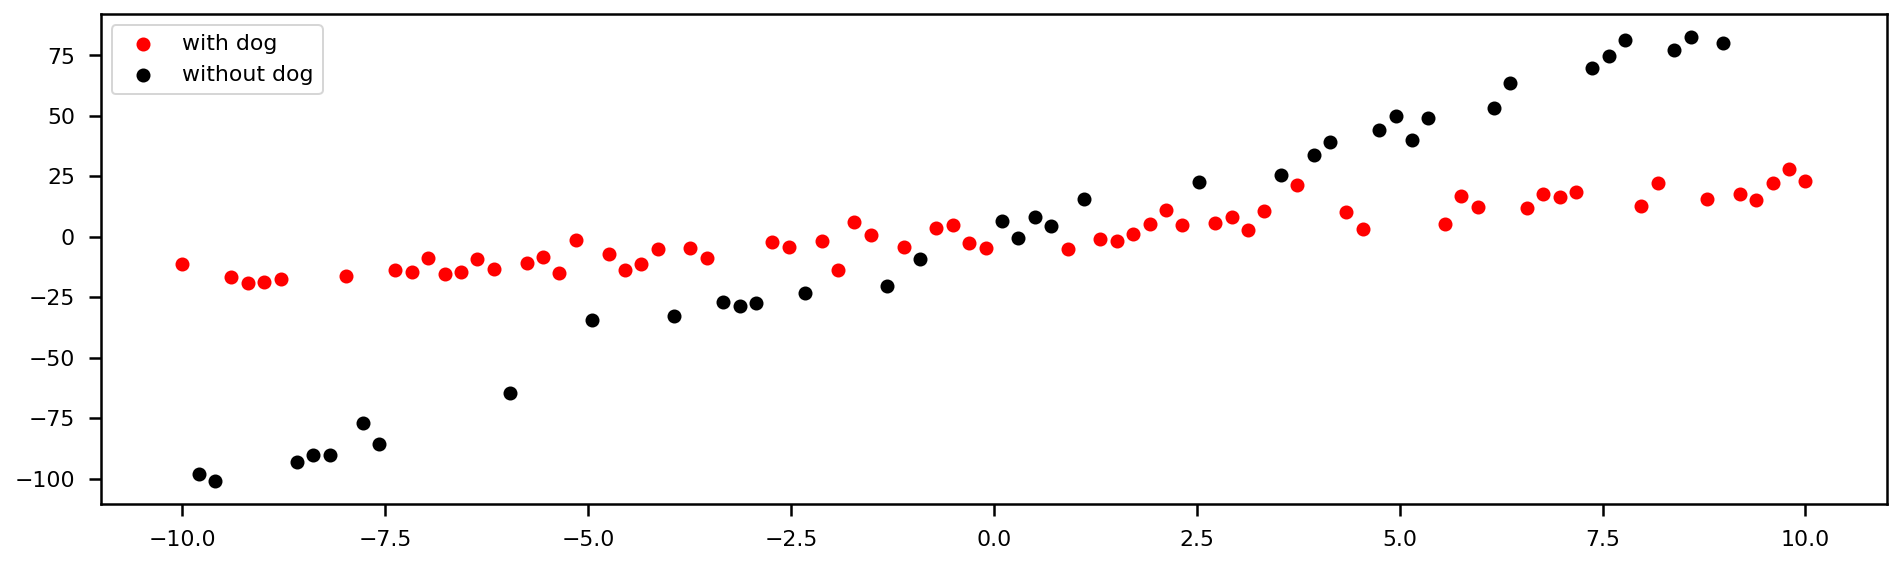

In [9]:
index = X[:,1] == True

plt.scatter(X[:,0][index],y[index],label='with dog',c='red')
plt.scatter(X[:,0][~index],y[~index],label='without dog',c='black')
plt.legend()

# Now that we have defined the Problem, let's solve it!

Remember the simple API we defined last time. We will reuse it.
We will implement a way of choosing an arm to play according to some policy, and we will implement a way of updating the policy with the observations. Note that this time, we add context to both methods, and we explicity pass a model that will help us solve the problem.




In [0]:
class AbstractContextualSolver(object):
  def __init__(self, model, num_arms):
    self.model = model
    self.num_arms = num_arms


  def choose_arm(self,context):
    """choose an arm to play according to internal policy"""
    raise NotImplementedError
        
  def update(self, arm, context, reward):
    """ update internal policy to reflect changed knowledge"""
    raise NotImplementedError

But wait! 
We learned last time that in order to do thompson sampling, we need a distribution to draw from per arm we want to play; this distribution reflects the likelihood for the reward we're likely to receive. 
We also know that distributions usually don't use context; $ \mathcal{N}(\mu,\sigma)$ relies only on the mean and the standard deviation of the data we have observed - but in our case, $\mu$ changes rapidly with depending on whether a dog is present or not.
What do we do?


We become Bayesian, that's what we do. Honestly, that should always be the first thing you do when facing a problem.

![alt](https://upload.wikimedia.org/wikipedia/commons/thumb/1/18/Bayes%27_Theorem_MMB_01.jpg/1200px-Bayes%27_Theorem_MMB_01.jpg)

More specifically, we will use a technique known as bayesian linear regression, which you can read about more about [here](https://en.wikipedia.org/wiki/Bayesian_linear_regression) and [here](https://towardsdatascience.com/introduction-to-bayesian-linear-regression-e66e60791ea7). Let's meet again after you checked those out. 



Hi! So now that you read that, you know how Bayesian Linear Regression can be used to derive a normal distribution depending on a linear model that we can train to give us everything we need. 
Let's do that. 



In [0]:
class BayesLinReg(object):

  def __init__(self, num_features=1,v=v):
    self.B = np.eye(num_features+1)
    self.Binv = np.linalg.inv(self.B)
    self.f = np.atleast_2d(np.zeros(num_features+1))
    self.v = v

    self.mu = np.zeros(num_features+1)

  def add_intercept(self,X):
    X_new = np.atleast_2d(np.insert(np.atleast_2d(X),0,1))
    return X_new.T


  def observe(self,x,y):
    y = np.atleast_2d(y)
    x = self.add_intercept(x)
    self.B += np.outer(x,x)
    self.f += np.dot(x,y).T


  def get_mean_std(self):
      B_inv = np.linalg.inv(self.B)
      mu_t = B_inv.dot(self.f.T)

      return mu_t, B_inv

      

#helpers
  def train(self,X,y,shuffle = True):
      index = list(range(X.shape[0]))
      if shuffle ==True:
          np.random.shuffle(index)
      for i in index:
          self.observe(X[i],y[i]) 
          

      
  def predict_ML(self,X):
      beta= np.linalg.inv(self.B).dot(self.f.T)

      y = []
      try:
          for i in range(len(X)):
              x = X[i]
              y += [self.predict_ML_x(x)]
              return y
      except:
          X = self.add_intercept(X)
          return X.T.dot(beta)
          




  def predict_ML_x(self,x):
      beta = np.linalg.inv(self.B).dot(self.f.T)
      x = self.add_intercept(x)
      return x.T.dot(beta)[0][0]

  def draw(self):
      B_inv = np.linalg.inv(self.B)
      mu_t = B_inv.dot(self.f.T)
      dist = stats.multivariate_normal
      return dist.rvs(mean=mu_t.flatten(),cov=self.v**2*B_inv)   

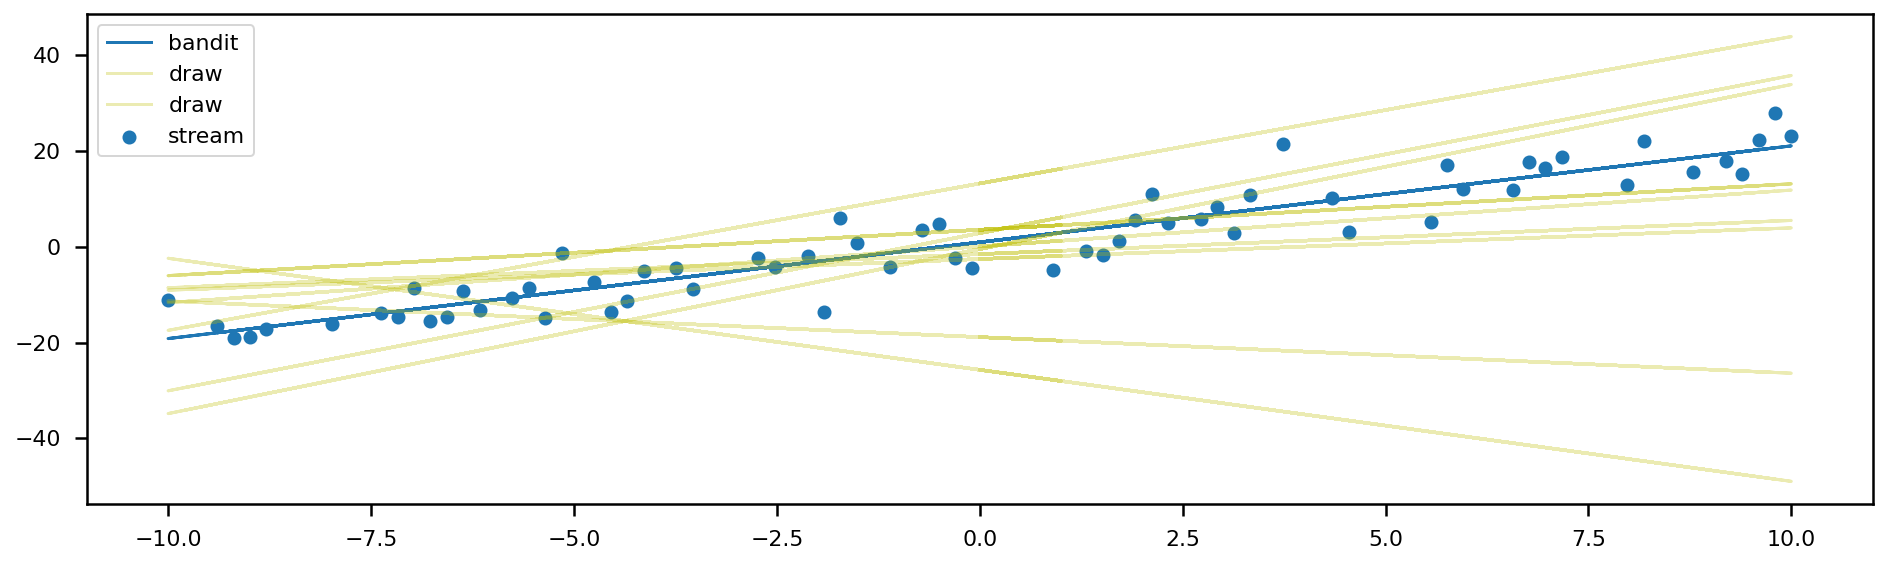

In [12]:
bl = BayesLinReg()
bl.train(X[:,0][index],y[index])

draw_list = []


num_draws = 10
#plt.scatter(X,y)

#plt.plot(X,regr.predict(X),label = 'ols',alpha=.3)
#plt.scatter(X,y_hat,color = 'r',label = 'ML')


y_hat = []

for i in range(len(X[index])):
    y_hat += [bl.predict_ML_x(X[:,0][index][i])]

y_hat = np.array(y_hat) 

plt.plot(X[:,0][index],y_hat,label='bandit')
plt.scatter(X[:,0][index],y[index],label='stream')

for i in range(num_draws-1):
    w = bl.draw()
    draw_list += [w]
#plt.plot(X,X*w,label='draws')
#draw = w.dot(test.add_intercept(X[1]))
#draw_list +=[draw]

    plt.plot(X,w[0]+w[1]*X,color = 'y',alpha=0.3)
plt.plot(X,w[0]+w[1]*X,label='draw',color = 'y',alpha=0.3)

plt.legend()

# so how does the sampler look like?

In [0]:
class GaussianThompsonSampler(AbstractContextualSolver):
  """solves the contextual MAB problem with normal reward distribution
  by utilising a model to predict the distribution 
  for each context and each arm individually"""

  def choose_arm(self,context):
    reward_list = []

    for i in range(self.num_arms):
        mu_t, B_inv = self.model.get_mean_std()

        dist = stats.multivariate_normal

        sample_slope = np.atleast_2d(dist.rvs(mean=mu_t.flatten(),cov=self.model.v**2*B_inv))
        #print(sample_slope)

        reward = np.dot(context.T,sample_slope.T)
        reward = sample_slope
        reward_list += [reward]
    return np.argmax(reward_list)

  def update(self,arm,context,reward):
    X = np.append(context,arm)
    self.model.observe(X, reward)

In [0]:
from fastprogress.fastprogress import master_bar, progress_bar


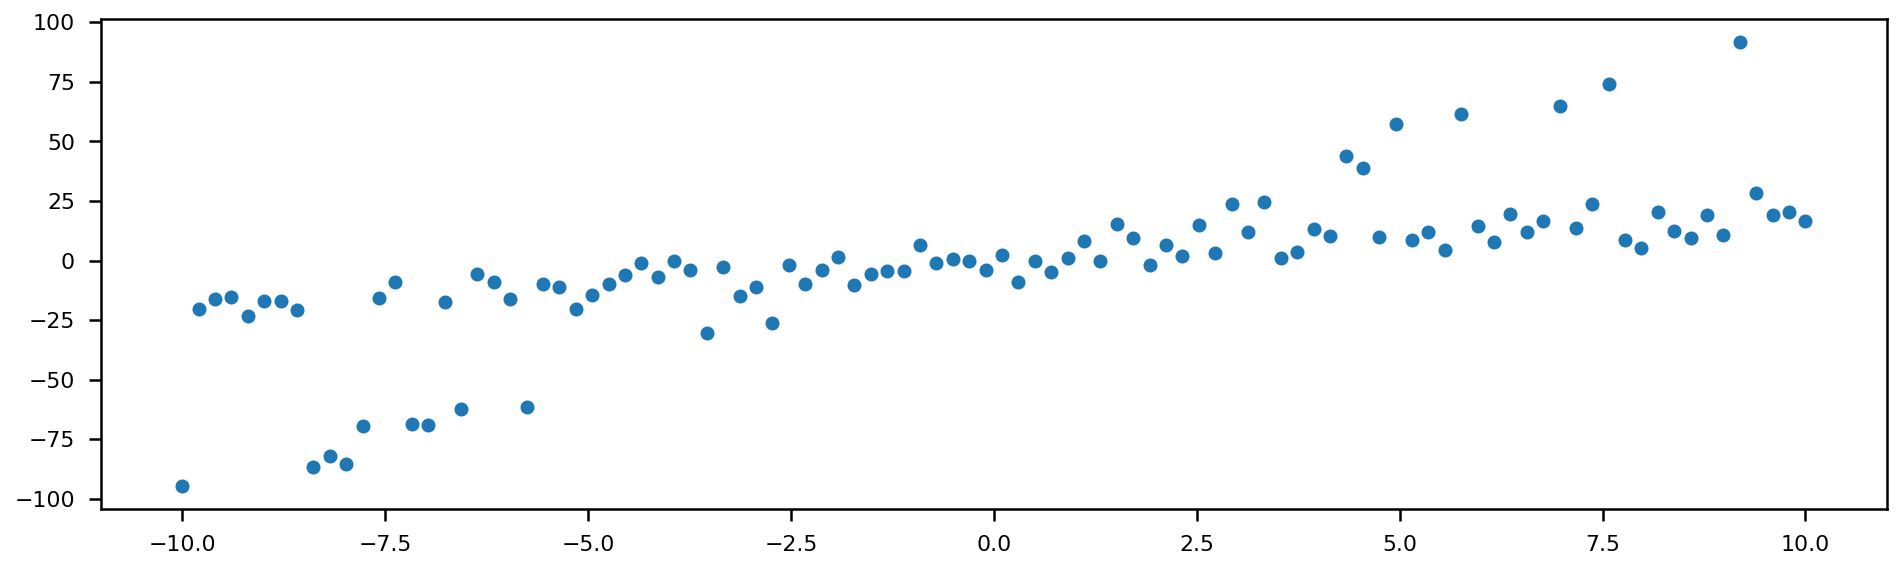

In [17]:
breg = BayesLinReg(num_features=2)
gts = GaussianThompsonSampler(breg,num_arms = 2)

context = X[:,0]

#seed = 12
#seed = seed +1
#np.random.seed(seed)
y_hat_list = []
for i in progress_bar(range(num_data)):
  arm = gts.choose_arm(context[i])
  # X = np.append(context[i],arm)


  y_hat = customer_reaction(context[i],arm)
  y_hat_list += [y_hat]
  gts.update(arm, context[i], y_hat)
  
plt.scatter(context,y_hat_list)

In [16]:
context

2.525252525252524